---
title: "Lab 7: Heart Attack"
format: 
  html:
    embed-resources: true
execute:
  echo: true
code-fold: true
author: James Compagno
jupyter: python3
---

# The Data

In this lab, we will use medical data to predict the likelihood of a person experiencing an exercise-induced heart attack.

Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise. The information collected includes:

- **age**: Age of the patient

- **sex**: Sex of the patient

- **cp**: Chest Pain type
  - Value 0: asymptomatic
  - Value 1: typical angina
  - Value 2: atypical angina
  - Value 3: non-anginal pain

- **trtbps**: resting blood pressure (in mm Hg)

- **chol**: cholesterol in mg/dl fetched via BMI sensor

- **restecg**: resting electrocardiographic results
  - Value 0: normal
  - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

- **thalach**: maximum heart rate achieved during exercise

- **output**: the doctor's diagnosis of whether the patient is at risk for a heart attack
  - 0 = not at risk of heart attack
  - 1 = at risk of heart attack

Although it is not a formal question on this assignment, you should begin by reading in the dataset and briefly exploring and summarizing the data, and by adjusting any variables that need cleaning.

In [242]:
import numpy as np
import pandas as pd
import plotnine as p9
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict

In [243]:
# Read the data
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha = ha.dropna()

ha.describe()

,age,sex,cp,trtbps,chol,restecg,thalach,output
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,54.347985,0.673993,0.974359,132.098901,246.860806,0.538462,149.446886,0.534799
std,9.163134,0.469611,1.030456,17.700358,52.569726,0.528059,23.240707,0.499704
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,211.000000,0.000000,133.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,1.000000,152.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,1.000000,166.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,2.000000,202.000000,1.000000


In [244]:
# Chest Pain
print("Distribution:")
print(ha['cp'].value_counts().sort_index())
print("\nProportions:")
print(ha['cp'].value_counts(normalize=True).sort_index())

Distribution:
cp
0    128
1     44
2     81
3     20
Name: count, dtype: int64

Proportions:
cp
0    0.468864
1    0.161172
2    0.296703
3    0.073260
Name: proportion, dtype: float64


With almost 50% of patients expirencing asymtomatic chest pain more must be looked ast besides that especially since doctors later went on to diagnose 34/128 "asymtomatic" patients as "At Risk." 

In [245]:
# Separate X and Y
y = ha['output']
X = ha.drop(columns=['output'])

# Numeric and Categorical 
categorical_features = ['sex', 'cp', 'restecg']
numerical_features = ['age', 'trtbps', 'chol', 'thalach']

# Model Library 
model_library = {}
records = []

In [246]:
# Column Transformer 
ct = ColumnTransformer(
    [
        ("standardize", 
         StandardScaler(), 
         numerical_features),
        ("encode",
         OneHotEncoder(drop='first', sparse_output=False),
         categorical_features)
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Part One: Fitting Models

This section asks you to create a final best model for each of the model types studied this week. For each, you should:

- Find the best model based on `ROC AUC` for predicting the `target` variable.

- Report the (cross-validated!) `ROC AUC` metric.

- Fit the final model.

- Output a **confusion matrix**; that is, the counts of how many observations fell into each predicted class for each true class.

- (Where applicable) Interpret the coefficients and/or estimates produced by the model fit.

You should certainly try multiple model pipelines to find the best model. You do not need to include the output for every attempted model, but you should describe all of the models explored. You *should* include any hyperparameter tuning steps in your writeup as well.

## Q1: KNN

In [247]:
def knn_gridsearch(model_name, features=None, k_range=None):
    """
    Uses GridSearchCV to find the best K value for KNN
    model_name - will be stored in model_library
    k_range - list of k values to test 
    features - list or None 
    """
    
    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Pipeline with KNN Classifier
    pipe = Pipeline([
        ("preprocess", ct),
        ("knn", KNeighborsClassifier())
    ])
    
    # Parameter grid
    param_grid = {
        'knn__n_neighbors': k_range 
    }
    
    # GridSearchCV ROC AUC 
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    grid_search.fit(X_subset, y)
    
    # Store best model
    best_model = grid_search.best_estimator_
    model_library[model_name] = best_model
    
    # Best parameters
    best_k = grid_search.best_params_['knn__n_neighbors']
    
    # Cross-validated predictions
    y_pred_cv = cross_val_predict(best_model, X_subset, y, cv=5)
    y_proba_cv = cross_val_predict(best_model, X_subset, y, cv=5, method='predict_proba')[:, 1]
    
    # Metrics on CV predictions
    conf_matrix = confusion_matrix(y, y_pred_cv, labels=[0, 1])
    tn, fp, fn, tp = conf_matrix.ravel()
    
    cv_roc_auc = roc_auc_score(y, y_proba_cv)
    cv_accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv, zero_division=0)
    recall = recall_score(y, y_pred_cv, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Store results
    records.append({
        "Model": model_name,
        "Classification Type": "KNN",
        "Variables Used": len(X_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "KNNeighbors", 
        "Hyperparameter 1 Value": best_k,
        "Hyperparameter 2 Name": "NA", 
        "Hyperparameter 2 Value": "NA",
        "Range Tested": k_range,
        "ROC AUC": cv_roc_auc,
        "CV Accuracy": cv_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
    })
    
    # Print
    print("Confusion Matrix (CV):")
    print(conf_matrix)

    return 

In [248]:
knn_gridsearch("KNN_Prime", k_range=[3, 5, 7, 9, 11, 13, 15])

Confusion Matrix (CV):
[[ 92  35]
 [ 45 101]]


In [249]:
knn_gridsearch("KNN_Wide", k_range=[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51])

Confusion Matrix (CV):
[[ 92  35]
 [ 45 101]]


In [250]:
knn_gridsearch("KNN_Evens", k_range=[2, 4, 6, 8, 10, 12, 14, 16])

Confusion Matrix (CV):
[[107  20]
 [ 59  87]]


In [251]:
dfKNN = pd.DataFrame(records)
dfKNN[dfKNN['Classification Type'] == 'KNN'].sort_values('ROC AUC', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC,CV Accuracy,Confusion Matrix,Precision,Recall,Specificity
0,KNN_Prime,KNN,All,KNNeighbors,7,NA,NA,"[3, 5, 7, 9, 11, 13, 15]",0.785352,0.706960,"[[92, 35], [45, 101]]",0.742647,0.691781,0.724409
1,KNN_Wide,KNN,All,KNNeighbors,7,NA,NA,"[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51]",0.785352,0.706960,"[[92, 35], [45, 101]]",0.742647,0.691781,0.724409
2,KNN_Evens,KNN,All,KNNeighbors,6,NA,NA,"[2, 4, 6, 8, 10, 12, 14, 16]",0.785083,0.710623,"[[107, 20], [59, 87]]",0.813084,0.595890,0.842520


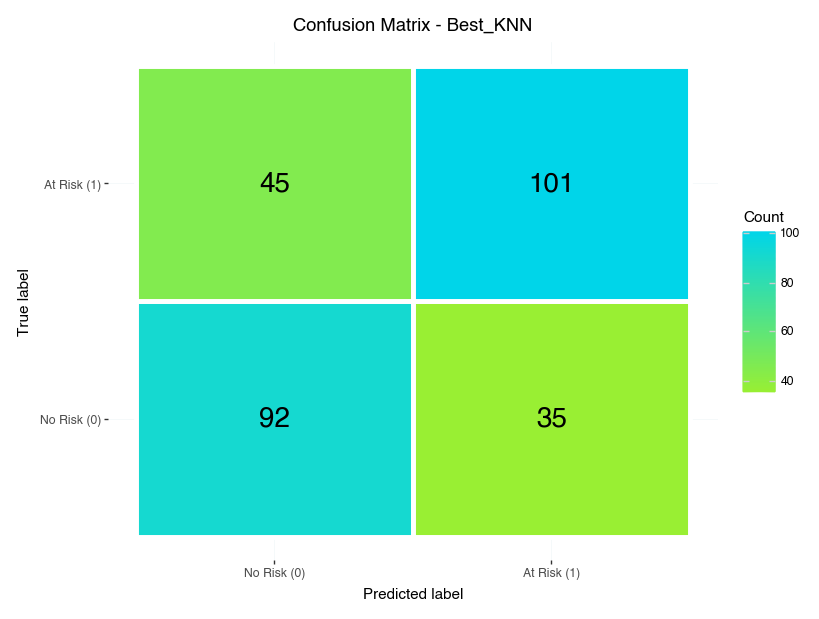

In [252]:
# Select the best KNN model
best_knn_model = model_library['KNN_Prime']

# Cross-validated predictions
knn_oof = cross_val_predict(best_knn_model, X, y, cv=5, method='predict_proba')[:, 1]
y_pred_oof = (knn_oof >= 0.5).astype(int)

# Calculate metrics
cm_oof = confusion_matrix(y, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm_oof.ravel()

# Create dataframe 
cm_df = pd.DataFrame({
    'True_Label': [0, 0, 1, 1],
    'Predicted_Label': [0, 1, 0, 1],
    'Count': [tn, fp, fn, tp]
})

# Plot
(p9.ggplot(cm_df, p9.aes(x='factor(Predicted_Label)', y='factor(True_Label)', fill='Count'))
    + p9.geom_tile(color='white', size=2)
    + p9.geom_text(p9.aes(label='Count'), size=20, color='black')
    + p9.scale_fill_gradient(low='#99ef33', high='#00d5e9')
    + p9.scale_x_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.scale_y_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.labs(
        title='Confusion Matrix - Best_KNN',
        x='Predicted label',
        y='True label'
    )
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        panel_background=p9.element_rect(fill="white"), 
        panel_grid_major=p9.element_line(color="#f2f7f8", size=0.5)
    )
)

The KNN model achieved a ROC AUC of 0.79, demonstrating good ability to distinguish between at-risk and no-risk patients.

It captured about 69% of actual at-risk patients (recall/sensitivity) and was correct 74% of the time when predicting someone as at-risk (precision).

It correctly identified 72% of no-risk patients (specificity).

The main concern is the model missed 45 at-risk patients (false negatives) and incorrectly flagged 35 no-risk patients as at-risk (false positives).

Overall: This is a solid performing model with K=7 neighbors, though the 45 false negatives are concerning from a medical perspective where missing at-risk patients could have serious consequences.

## Q2: Logistic Regression

In [253]:
def logistic_gridsearch(model_name, features=None, C_range=None):
    """
    Uses GridSearchCV to find the best hyperparameters for Logistic Regression with ElasticNet
    model_name - will be stored in model_library
    C_range - list of regularization strength values to test 
    features - list or None 
    """

    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Pipeline with Logistic Regression (ElasticNet penalty)
    pipe = Pipeline([
        ("preprocess", ct),
        ("logistic", LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000, random_state=67, l1_ratio=0.5))
    ])
    
    # Parameter grid
    param_grid = {
        'logistic__C': C_range
    }
    
    # GridSearchCV ROC AUC 
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    grid_search.fit(X_subset, y)
    
    # Store best model
    best_model = grid_search.best_estimator_
    model_library[model_name] = best_model
    
    # Best parameters
    best_C = grid_search.best_params_['logistic__C']
    
    # Cross-validated predictions
    y_pred_cv = cross_val_predict(best_model, X_subset, y, cv=5)
    y_proba_cv = cross_val_predict(best_model, X_subset, y, cv=5, method='predict_proba')[:, 1]
    
    # Metrics on CV predictions
    conf_matrix = confusion_matrix(y, y_pred_cv, labels=[0, 1])
    tn, fp, fn, tp = conf_matrix.ravel()
    
    cv_roc_auc = roc_auc_score(y, y_proba_cv)
    cv_accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv, zero_division=0)
    recall = recall_score(y, y_pred_cv, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Store results
    records.append({
        "Model": model_name,
        "Classification Type": "Logistic",
        "Variables Used": len(X_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "C", 
        "Hyperparameter 1 Value": best_C,
        "Hyperparameter 2 Name": "ElasticNet L1",
        "Hyperparameter 2 Value": 0.5,
        "Range Tested": C_range,
        "ROC AUC": cv_roc_auc,
        "CV Accuracy": cv_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity
    })
    
    # Print
    print("Confusion Matrix (CV):")
    print(conf_matrix)
    
    return

In [254]:
logistic_gridsearch("Logistic_Basic",  C_range=[0.001, 0.01, 0.1, 1, 10, 100])

Confusion Matrix (CV):
[[ 95  32]
 [ 28 118]]


/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [255]:
logistic_gridsearch("Logistic_Wide", C_range=[0.001, 0.01, 0.1, 1, 10, 100, 1000])

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Confusion Matrix (CV):
[[ 95  32]
 [ 28 118]]


In [256]:
logistic_gridsearch("Logistic_Strong", C_range=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1])

Confusion Matrix (CV):
[[ 83  44]
 [ 30 116]]


In [257]:
dflog = pd.DataFrame(records)
dflog[dflog['Classification Type'] == 'Logistic'].sort_values('ROC AUC', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC,CV Accuracy,Confusion Matrix,Precision,Recall,Specificity
3,Logistic_Basic,Logistic,All,C,1.0,ElasticNet L1,0.5,"[0.001, 0.01, 0.1, 1, 10, 100]",0.857782,0.780220,"[[95, 32], [28, 118]]",0.786667,0.808219,0.748031
4,Logistic_Wide,Logistic,All,C,1.0,ElasticNet L1,0.5,"[0.001, 0.01, 0.1, 1, 10, 100, 1000]",0.857782,0.780220,"[[95, 32], [28, 118]]",0.786667,0.808219,0.748031
5,Logistic_Strong,Logistic,All,C,0.1,ElasticNet L1,0.5,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]",0.819006,0.728938,"[[83, 44], [30, 116]]",0.725000,0.794521,0.653543


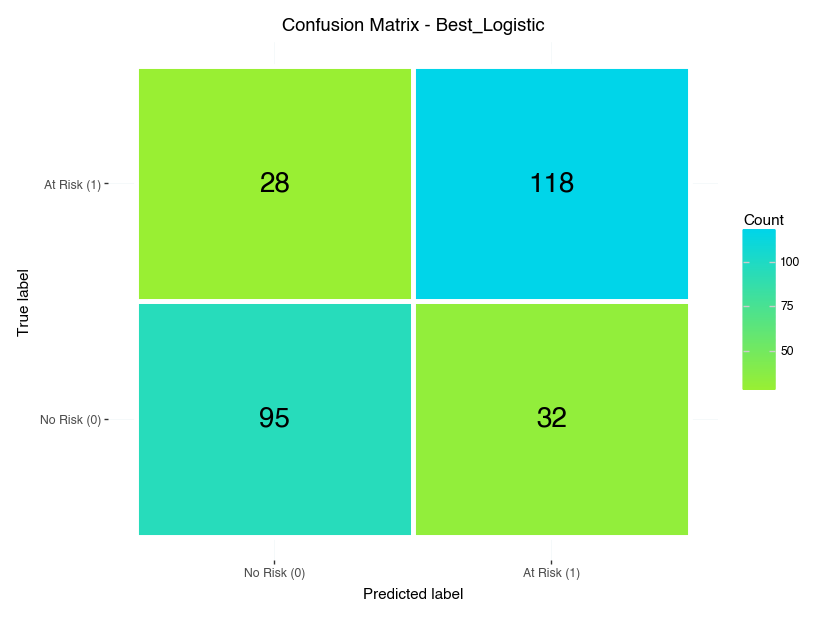

In [258]:
# Select the best Logistic model
best_logistic_model = model_library['Logistic_Wide']

# Cross-validated predictions
logistic_oof = cross_val_predict(best_logistic_model, X, y, cv=5, method='predict_proba')[:, 1]
y_pred_oof = (logistic_oof >= 0.5).astype(int)

# Calculate metrics
cm_oof = confusion_matrix(y, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm_oof.ravel()

# Create dataframe 
cm_df = pd.DataFrame({
    'True_Label': [0, 0, 1, 1],
    'Predicted_Label': [0, 1, 0, 1],
    'Count': [tn, fp, fn, tp]
})

# Plot
(p9.ggplot(cm_df, p9.aes(x='factor(Predicted_Label)', y='factor(True_Label)', fill='Count'))
    + p9.geom_tile(color='white', size=2)
    + p9.geom_text(p9.aes(label='Count'), size=20, color='black')
    + p9.scale_fill_gradient(low='#99ef33', high='#00d5e9')
    + p9.scale_x_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.scale_y_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.labs(
        title='Confusion Matrix - Best_Logistic',
        x='Predicted label',
        y='True label'
    )
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        panel_background=p9.element_rect(fill="white"), 
        panel_grid_major=p9.element_line(color="#f2f7f8", size=0.5)
    )
)

The Logistic Regression model achieved a ROC AUC of 0.86, better than KNN (0.79). 

It captured about 81% of actual at-risk patients (recall/sensitivity) and was correct 79% of the time when predicting someone as at-risk (precision).

It correctly identified 75% of no-risk patients (specificity).

The main concern is the model missed 28 at-risk patients (false negatives) and incorrectly flagged 32 no-risk patients as at-risk (false positives).

Overall: While it has fewer false negatives (28 vs 45 for KNN), which is crucial in medical diagnosis, it does have slightly fewer false positives as well (32 vs 35). This makes it the stronger model overall.

## Q3: Decision Tree

In [259]:
def tree_gridsearch(model_name, features=None, max_depth_range=None):
    """
    Uses GridSearchCV to find the best max_depth for Decision Tree
    model_name - will be stored in model_library
    max_depth_range - list of max_depth values to test
    features - list or None 
    """
    
    # Select features
    if features is not None:
        X_subset = X[features]
    else:
        X_subset = X
    
    # Pipeline with Decision Tree
    pipe = Pipeline([
        ("preprocess", ct),
        ("tree", DecisionTreeClassifier(random_state=67))
    ])
    
    # Parameter grid
    param_grid = {
        'tree__max_depth': max_depth_range
    }
    
    # GridSearchCV ROC AUC 
    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        return_train_score=True,
        n_jobs=-1
    )
    grid_search.fit(X_subset, y)
    
    # Store best model
    best_model = grid_search.best_estimator_
    model_library[model_name] = best_model
    
    # Best parameters
    best_max_depth = grid_search.best_params_['tree__max_depth']
    
    # Cross-validated predictions
    y_pred_cv = cross_val_predict(best_model, X_subset, y, cv=5)
    y_proba_cv = cross_val_predict(best_model, X_subset, y, cv=5, method='predict_proba')[:, 1]
    
    # Metrics on CV predictions
    conf_matrix = confusion_matrix(y, y_pred_cv, labels=[0, 1])
    tn, fp, fn, tp = conf_matrix.ravel()
    
    cv_roc_auc = roc_auc_score(y, y_proba_cv)
    cv_accuracy = accuracy_score(y, y_pred_cv)
    precision = precision_score(y, y_pred_cv, zero_division=0)
    recall = recall_score(y, y_pred_cv, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    
    # Store results
    records.append({
        "Model": model_name,
        "Classification Type": "Decision Tree",
        "Variables Used": len(X_subset.columns) if features else "All",
        "Hyperparameter 1 Name": "Max Depth", 
        "Hyperparameter 1 Value": best_max_depth,
        "Hyperparameter 2 Name": "NA",
        "Hyperparameter 2 Value": "NA",
        "Range Tested": max_depth_range,
        "ROC AUC": cv_roc_auc,
        "CV Accuracy": cv_accuracy,
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity
    })
    
    # Print
    print("Confusion Matrix (CV):")
    print(conf_matrix)
    
    return

In [260]:
tree_gridsearch("Tree_Prime", max_depth_range=[3, 5, 7, 9, 11, 13, 15])

Confusion Matrix (CV):
[[ 87  40]
 [ 42 104]]


In [261]:
tree_gridsearch("Tree_Wide", max_depth_range=[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51])

Confusion Matrix (CV):
[[ 87  40]
 [ 42 104]]


In [262]:
tree_gridsearch("Tree_Evens", max_depth_range=[2, 4, 6, 8, 10, 12, 14, 16])

Confusion Matrix (CV):
[[ 85  42]
 [ 39 107]]


In [263]:
dfTree = pd.DataFrame(records)
dfTree[dfTree['Classification Type'] == 'Decision Tree'].sort_values('ROC AUC', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC,CV Accuracy,Confusion Matrix,Precision,Recall,Specificity
8,Tree_Evens,Decision Tree,All,Max Depth,2.0,NA,NA,"[2, 4, 6, 8, 10, 12, 14, 16]",0.746521,0.703297,"[[85, 42], [39, 107]]",0.718121,0.732877,0.669291
6,Tree_Prime,Decision Tree,All,Max Depth,3.0,NA,NA,"[3, 5, 7, 9, 11, 13, 15]",0.728293,0.699634,"[[87, 40], [42, 104]]",0.722222,0.712329,0.685039
7,Tree_Wide,Decision Tree,All,Max Depth,3.0,NA,NA,"[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51]",0.728293,0.699634,"[[87, 40], [42, 104]]",0.722222,0.712329,0.685039


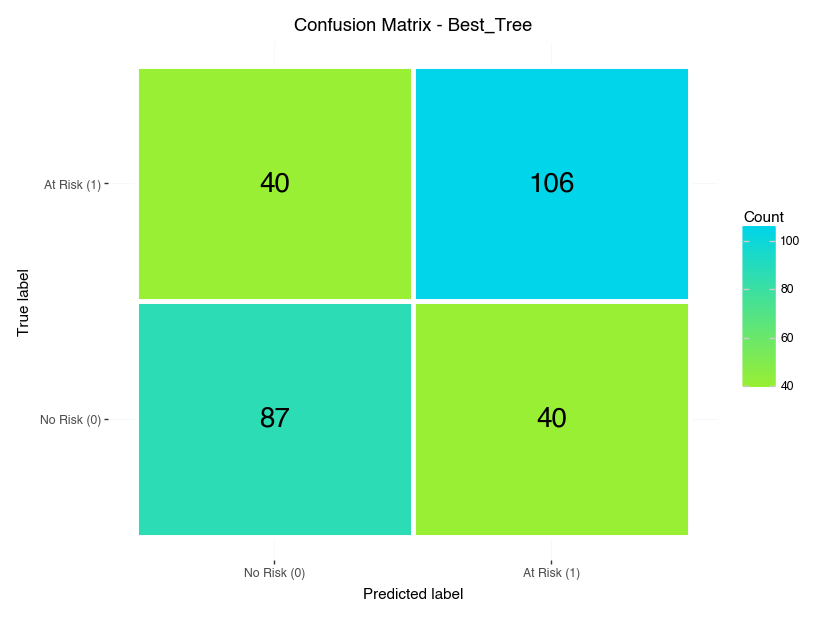

In [264]:
# Select the best Tree model
best_tree_model = model_library['Tree_Wide']

# Cross-validated predictions
tree_oof = cross_val_predict(best_tree_model, X, y, cv=5, method='predict_proba')[:, 1]
y_pred_oof = (tree_oof >= 0.5).astype(int)

# Calculate metrics
cm_oof = confusion_matrix(y, y_pred_oof, labels=[0, 1])
tn, fp, fn, tp = cm_oof.ravel()

# Create dataframe 
cm_df = pd.DataFrame({
    'True_Label': [0, 0, 1, 1],
    'Predicted_Label': [0, 1, 0, 1],
    'Count': [tn, fp, fn, tp]
})

# Plot
(p9.ggplot(cm_df, p9.aes(x='factor(Predicted_Label)', y='factor(True_Label)', fill='Count'))
    + p9.geom_tile(color='white', size=2)
    + p9.geom_text(p9.aes(label='Count'), size=20, color='black')
    + p9.scale_fill_gradient(low='#99ef33', high='#00d5e9')
    + p9.scale_x_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.scale_y_discrete(labels=['No Risk (0)', 'At Risk (1)'])
    + p9.labs(
        title='Confusion Matrix - Best_Tree',
        x='Predicted label',
        y='True label'
    )
    + p9.theme(figure_size=(8, 6))
    + p9.theme(
        panel_background=p9.element_rect(fill="white"), 
        panel_grid_major=p9.element_line(color="#f2f7f8", size=0.5)
    )
)

The Decision Tree model achieved a ROC AUC of 0.75, lower than both KNN (0.79) and Logistic (0.86).

It captured about 73% of actual at-risk patients (recall/sensitivity) and was correct 72% of the time when predicting someone as at-risk (precision).

It correctly identified 67% of no-risk patients (specificity).

The main concern is the model missed 39 at-risk patients (false negatives) and incorrectly flagged 42 no-risk patients as at-risk (false positives).

Overall: This is the weakest performer among the three models. It has the most false negatives (39), most false positives (42), and lowest ROC AUC, suggesting it struggles compared to KNN and Logistic Regression.

## Q4: Interpretation

Which predictors were most important to predicting heart attack risk?

In [265]:
pd.DataFrame(records).sort_values('ROC AUC', ascending=False).head(3)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC,CV Accuracy,Confusion Matrix,Precision,Recall,Specificity
3,Logistic_Basic,Logistic,All,C,1.0,ElasticNet L1,0.5,"[0.001, 0.01, 0.1, 1, 10, 100]",0.857782,0.780220,"[[95, 32], [28, 118]]",0.786667,0.808219,0.748031
4,Logistic_Wide,Logistic,All,C,1.0,ElasticNet L1,0.5,"[0.001, 0.01, 0.1, 1, 10, 100, 1000]",0.857782,0.780220,"[[95, 32], [28, 118]]",0.786667,0.808219,0.748031
5,Logistic_Strong,Logistic,All,C,0.1,ElasticNet L1,0.5,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]",0.819006,0.728938,"[[83, 44], [30, 116]]",0.725000,0.794521,0.653543


In [266]:
best_logistic = model_library['Logistic_Wide']

feature_names = best_logistic.named_steps['preprocess'].get_feature_names_out()

logit_coefs = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": best_logistic.named_steps['logistic'].coef_[0]
}).sort_values("Coefficient", key=abs, ascending=False)


display(logit_coefs)

,Feature,Coefficient
4,sex_1,-1.844883
5,cp_1,1.730116
6,cp_2,1.672830
7,cp_3,1.310746
3,thalach,0.774489
8,restecg_1,0.314796
1,trtbps,-0.294855
2,chol,-0.258932
0,age,-0.209573
9,restecg_2,0.000000


Based on the Logistic Regression model (our best performer with ROC AUC = 0.86), the most important predictors were:

1. sex_1 (Male): Coefficient = -1.85 - Being male strongly decreases the predicted risk of heart attack in this model. This is the strongest predictor overall, though it goes against conventional medical wisdom.

2. cp_1 (Typical angina): Coefficient = 1.73 - Having typical angina chest pain strongly increases heart attack risk.

3. cp_2 (Atypical angina): Coefficient = 1.67 - Having atypical angina also strongly increases heart attack risk.

4. cp_3 (Non-anginal pain): Coefficient = 1.31 - Non-anginal chest pain moderately increases risk.

5. thalach (Max heart rate): Coefficient = 0.77 - Higher maximum heart rate during exercise increases heart attack risk.

The logistic regression coefficients reveal that sex and chest pain type are the strongest predictors of heart attack risk. Against conventional wisdom, being male decreases predicted risk in this model, while different types of chest pain (especially typical and atypical angina) are strong positive indicators. Other factors like blood pressure, cholesterol, and age had relatively smaller effects on predictions.

## 5: ROC Curve

Plot the ROC Curve for your three models above.

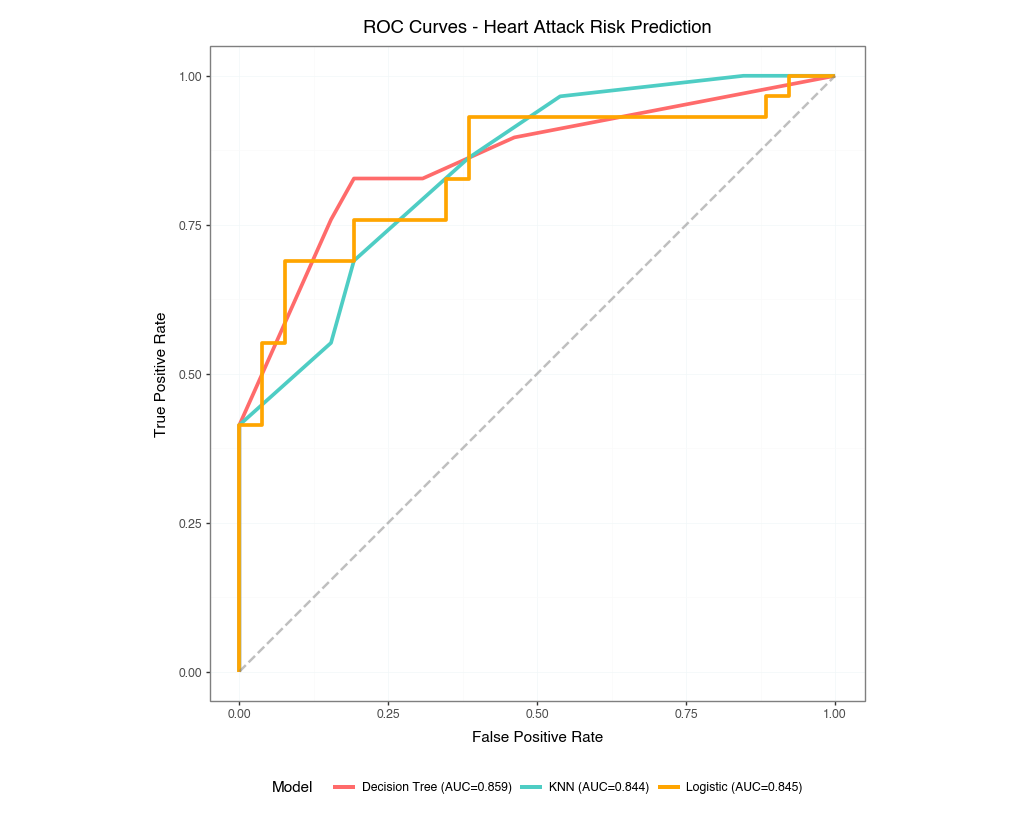

In [267]:
# Pick Models
best_knn = model_library['KNN_Wide']
# best_logistic = model_library['Logistic_Wide'] 
best_tree = model_library['Tree_Wide']

# Get predictions 
knn_proba = best_knn.predict_proba(X_test)[:, 1]
logistic_proba = best_logistic.predict_proba(X_test)[:, 1]
tree_proba = best_tree.predict_proba(X_test)[:, 1]

# Calculate ROC curves
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_proba)
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, logistic_proba)
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_proba)

# Calculate AUC scores
auc_knn = auc(fpr_knn, tpr_knn)
auc_logistic = auc(fpr_logistic, tpr_logistic)
auc_tree = auc(fpr_tree, tpr_tree)

# Create dataframes 
roc_knn = pd.DataFrame({'FPR': fpr_knn, 'TPR': tpr_knn, 'Model': f'KNN (AUC={auc_knn:.3f})'})
roc_logistic = pd.DataFrame({'FPR': fpr_logistic, 'TPR': tpr_logistic, 'Model': f'Logistic (AUC={auc_logistic:.3f})'})
roc_tree = pd.DataFrame({'FPR': fpr_tree, 'TPR': tpr_tree, 'Model': f'Decision Tree (AUC={auc_tree:.3f})'})

# All ROC curves
roc_df = pd.concat([roc_knn, roc_logistic, roc_tree])

# Diagonal line
diagonal_df = pd.DataFrame({'FPR': [0, 1], 'TPR': [0, 1]})


# Plot
(p9.ggplot()
    + p9.geom_line(roc_df, p9.aes(x='FPR', y='TPR', color='Model'), size=1.5)
    + p9.geom_line(diagonal_df, p9.aes(x='FPR', y='TPR'), 
                   color='gray', linetype='dashed', size=1, alpha=0.5)
    + p9.scale_color_manual(values=['#FF6B6B', '#4ECDC4', '#FFA500'])
    + p9.labs(
        title='ROC Curves - Heart Attack Risk Prediction',
        x='False Positive Rate',
        y='True Positive Rate',
        color='Model'
    )
    + p9.theme_bw()
    + p9.theme(
        figure_size=(10, 8),
        panel_background=p9.element_rect(fill='white'),
        panel_grid_major=p9.element_line(color='#f2f7f8', size=0.5),
        legend_position='bottom'
    )
    + p9.coord_equal()
)

The curve confirms Logistic Regression as the most reliable choice for predicting heart attack risk, despite how jaggid it is.

# Part Two: Metrics

Consider the following metrics:

- **True Positive Rate** or **Recall** or **Sensitivity** = Of the observations that are truly Class A, how many were predicted to be Class A?

- **Precision** or **Positive Predictive Value** = Of all the observations classified as Class A, how many of them were truly from Class A?

- **True Negative Rate** or **Specificity** or **Negative Predictive Value** = Of all the observations classified as NOT Class A, how many were truly NOT Class A?

Compute each of these metrics (cross-validated) for your three models (KNN, Logistic Regression, and Decision Tree) in Part One.

In [268]:
# Top model for each method 
best_models = pd.DataFrame(records)[
    pd.DataFrame(records)['Model'].isin(['KNN_Wide', 'Logistic_Wide', 'Tree_Wide'])
]

# Display the metrics
metrics_display = best_models[[
    'Model', 
    'Classification Type',
    'ROC AUC', 
    'Precision', 
    'Recall', 
    'Specificity'
]].set_index('Model')

display(metrics_display)

,Classification Type,ROC AUC,Precision,Recall,Specificity
Model,,,,,
KNN_Wide,KNN,0.785352,0.742647,0.691781,0.724409
Logistic_Wide,Logistic,0.857782,0.786667,0.808219,0.748031
Tree_Wide,Decision Tree,0.728293,0.722222,0.712329,0.685039


The table confirms Logistic Regression as the most reliable choice for predicting heart attack risk in all categories other than Recall where it is tied with KNN. 

# Part Three: Discussion

Suppose you have been hired by a hospital to create classification models for heart attack risk.

The following questions give a possible scenario for why the hospital is interested in these models. For each one, discuss:

- Which metric(s) you would use for model selection and why.

- Which of your final models (Part One Q1-3) you would recommend to the hospital, and why.

- What score you should expect for your chosen metric(s) using your chosen model to predict future observations.

In [269]:
pd.DataFrame(records).sort_values('ROC AUC', ascending=False)

,Model,Classification Type,Variables Used,Hyperparameter 1 Name,Hyperparameter 1 Value,Hyperparameter 2 Name,Hyperparameter 2 Value,Range Tested,ROC AUC,CV Accuracy,Confusion Matrix,Precision,Recall,Specificity
3,Logistic_Basic,Logistic,All,C,1.0,ElasticNet L1,0.5,"[0.001, 0.01, 0.1, 1, 10, 100]",0.857782,0.780220,"[[95, 32], [28, 118]]",0.786667,0.808219,0.748031
4,Logistic_Wide,Logistic,All,C,1.0,ElasticNet L1,0.5,"[0.001, 0.01, 0.1, 1, 10, 100, 1000]",0.857782,0.780220,"[[95, 32], [28, 118]]",0.786667,0.808219,0.748031
5,Logistic_Strong,Logistic,All,C,0.1,ElasticNet L1,0.5,"[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]",0.819006,0.728938,"[[83, 44], [30, 116]]",0.725000,0.794521,0.653543
0,KNN_Prime,KNN,All,KNNeighbors,7.0,NA,NA,"[3, 5, 7, 9, 11, 13, 15]",0.785352,0.706960,"[[92, 35], [45, 101]]",0.742647,0.691781,0.724409
1,KNN_Wide,KNN,All,KNNeighbors,7.0,NA,NA,"[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51]",0.785352,0.706960,"[[92, 35], [45, 101]]",0.742647,0.691781,0.724409
2,KNN_Evens,KNN,All,KNNeighbors,6.0,NA,NA,"[2, 4, 6, 8, 10, 12, 14, 16]",0.785083,0.710623,"[[107, 20], [59, 87]]",0.813084,0.595890,0.842520
8,Tree_Evens,Decision Tree,All,Max Depth,2.0,NA,NA,"[2, 4, 6, 8, 10, 12, 14, 16]",0.746521,0.703297,"[[85, 42], [39, 107]]",0.718121,0.732877,0.669291
6,Tree_Prime,Decision Tree,All,Max Depth,3.0,NA,NA,"[3, 5, 7, 9, 11, 13, 15]",0.728293,0.699634,"[[87, 40], [42, 104]]",0.722222,0.712329,0.685039
7,Tree_Wide,Decision Tree,All,Max Depth,3.0,NA,NA,"[1, 3, 5, 7, 9, 11, 15, 19, 25, 31, 41, 51]",0.728293,0.699634,"[[87, 40], [42, 104]]",0.722222,0.712329,0.685039


## Q1

The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.

If that is the case than we want to have false negatives as little as possible. Use Recall as the key metric since it measures how many actual at-risk patients we correctly identify. I recommend the Logistic Regression model because it has the lowest false negatives (28). This should prevent lawsuits but might lead to overuse of hospital resources.

## Q2

The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.

If that is the case we would prefer the model that is more selective in admitting patients. Use Precision as the key metric since it measures how many at-risk patients are actually high risk. I recommend the Logistic Regression model again because it had the best precision (79%). However, if space is truly a concern, KNN_Evens had the lowest false positive rate of 20 with only a ~7% drop in ROC AUC over the best Logistic model (Logistic_Wide). 

## Q3

The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.

As the best model (by ROC AUC) Logistic Regression is again likely to be the better option. It also shows what to pay attention to, with Chest Pain type being a clearly important metric with its variants being 3 of the top 5.

## Q4

The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.

As the best model (by Roc AUC) Logistic Regression is AGAIN likely to be the better option. Because it heavily emphasizes the Chest Pain metric which would be a great thing for trainee doctors to focus on as it gets them to spend time discussing symptoms with patients. 

# Part Four: Validation

Before sharing the dataset with you, I set aside a random 10% of the observations to serve as a final validation set.

Use each of your final models in Part One Q1-3, predict the `target` variable in the validation dataset.

For each, output a confusion matrix, and report the `ROC AUC`, the `precision`, and the `recall`.

Compare these values to the cross-validated estimates you reported in Part One and Part Two. Did our measure of model success turn out to be approximately correct for the validation data?

In [270]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

# Separate X and y for validation
y_val = ha_validation['output']
X_val = ha_validation.drop(columns=['output'])

# Model Library 
validation_model_library = {}
validation_records = []

In [271]:
# Set the best KNN model earlier in the code 
# best_knn_model = model_library['KNN_Prime']

# Make predictions
y_pred_val = best_knn_model.predict(X_val)
y_proba_val = best_knn_model.predict_proba(X_val)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_val, y_pred_val, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()

val_roc_auc = roc_auc_score(y_val, y_proba_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, zero_division=0)
recall = recall_score(y_val, y_pred_val, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Store validation results
validation_records.append({
    "Model": "KNN_Prime",
    "Classification Type": "KNN",
    "Validation ROC AUC": val_roc_auc,
    "Validation Accuracy": val_accuracy,
    "Validation Confusion Matrix": conf_matrix,
    "Validation Precision": precision,
    "Validation Recall": recall,
    "Validation Specificity": specificity
})

# Print results
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 8  3]
 [ 7 12]]


In [272]:
# Set the best Logistic model earlier in the code 
# best_logistic_model = model_library['Logistic_Wide']

# Make predictions
y_pred_val = best_logistic_model.predict(X_val)
y_proba_val = best_logistic_model.predict_proba(X_val)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_val, y_pred_val, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()

val_roc_auc = roc_auc_score(y_val, y_proba_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, zero_division=0)
recall = recall_score(y_val, y_pred_val, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Store validation results
validation_records.append({
    "Model": "Logistic_Wide",
    "Classification Type": "Logistic",
    "Validation ROC AUC": val_roc_auc,
    "Validation Accuracy": val_accuracy,
    "Validation Confusion Matrix": conf_matrix,
    "Validation Precision": precision,
    "Validation Recall": recall,
    "Validation Specificity": specificity
})

# Print results
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 8  3]
 [ 4 15]]


In [273]:
# Get the best Tree model
# best_tree_model = model_library['Tree_Wide']

# Make predictions
y_pred_val = best_tree_model.predict(X_val)
y_proba_val = best_tree_model.predict_proba(X_val)[:, 1]

# Calculate metrics
conf_matrix = confusion_matrix(y_val, y_pred_val, labels=[0, 1])
tn, fp, fn, tp = conf_matrix.ravel()

val_roc_auc = roc_auc_score(y_val, y_proba_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, zero_division=0)
recall = recall_score(y_val, y_pred_val, zero_division=0)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# Store validation results
validation_records.append({
    "Model": "Tree_Wide",
    "Classification Type": "Decision Tree",
    "Validation ROC AUC": val_roc_auc,
    "Validation Accuracy": val_accuracy,
    "Validation Confusion Matrix": conf_matrix,
    "Validation Precision": precision,
    "Validation Recall": recall,
    "Validation Specificity": specificity
})

# Print results
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 8  3]
 [ 7 12]]


In [274]:
pd.DataFrame(validation_records).sort_values('Validation ROC AUC', ascending=False)

,Model,Classification Type,Validation ROC AUC,Validation Accuracy,Validation Confusion Matrix,Validation Precision,Validation Recall,Validation Specificity
1,Logistic_Wide,Logistic,0.875598,0.766667,"[[8, 3], [4, 15]]",0.833333,0.789474,0.727273
0,KNN_Prime,KNN,0.801435,0.666667,"[[8, 3], [7, 12]]",0.800000,0.631579,0.727273
2,Tree_Wide,Decision Tree,0.708134,0.666667,"[[8, 3], [7, 12]]",0.800000,0.631579,0.727273


In [275]:
# Comparison dataframe
comparison_data = []
df_records = pd.DataFrame(records)
model_names = ['KNN_Prime', 'Logistic_Wide', 'Tree_Wide']

for model_name in model_names:
    cv_row = df_records[df_records['Model'] == model_name].iloc[0]
    val_row = best_validation_models[best_validation_models['Model'] == model_name].iloc[0]
    comparison_data.append({
        'Model': model_name,
        'ROC AUC': cv_row['ROC AUC'],
        'Val ROC AUC': val_row['Validation ROC AUC'],
        'ROC Diff': val_row['Validation ROC AUC'] - cv_row['ROC AUC'],
        'Precision': cv_row['Precision'],
        'Val Precision': val_row['Validation Precision'],
        'Precision Diff': val_row['Validation Precision'] - cv_row['Precision'],
        'Recall': cv_row['Recall'],
        'Val Recall': val_row['Validation Recall'],
        'Recall Diff': val_row['Validation Recall'] - cv_row['Recall'],
        'Specificity': cv_row['Specificity'],
        'Val Specificity': val_row['Validation Specificity'],
        'Specificity Diff': val_row['Validation Specificity'] - cv_row['Specificity']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df


,Model,ROC AUC,Val ROC AUC,ROC Diff,Precision,Val Precision,Precision Diff,Recall,Val Recall,Recall Diff,Specificity,Val Specificity,Specificity Diff
0,KNN_Prime,0.785352,0.801435,0.016083,0.742647,0.800000,0.057353,0.691781,0.631579,-0.060202,0.724409,0.727273,0.002863
1,Logistic_Wide,0.857782,0.875598,0.017816,0.786667,0.833333,0.046667,0.808219,0.789474,-0.018745,0.748031,0.727273,-0.020759
2,Tree_Wide,0.728293,0.708134,-0.020159,0.722222,0.800000,0.077778,0.712329,0.631579,-0.080750,0.685039,0.727273,0.042233


The validation results mostly matched what we expected from cross-validation. ROC AUC, Precision, and Specificity were slightly better, but Recall dropped for all models.

# Part Five: Cohen's Kappa

Another common metric used in classification is Cohen's Kappa.

Use online resources to research this measurement. Calculate it for the models from Part One, Q1-3, and discuss reasons or scenarios that would make us prefer to use this metric as our measure of model success. Do your conclusions from above change if you judge your models using Cohen's Kappa instead? Does this make sense?

In [276]:
from sklearn.metrics import cohen_kappa_score

kappa_results = []

model_names = ['KNN_Prime', 'Logistic_Wide', 'Tree_Wide']

for model_name in model_names:
    model = model_library[model_name]
    y_pred_cv = cross_val_predict(model, X, y, cv=5)
    kappa = cohen_kappa_score(y, y_pred_cv)
    cv_row = df_records[df_records['Model'] == model_name].iloc[0]
    
    kappa_results.append({
        'Model': model_name,
        'Cohens Kappa': kappa,
        'ROC AUC': cv_row['ROC AUC'],
        'Accuracy': cv_row['CV Accuracy'],
        'Precision': cv_row['Precision'],
        'Recall': cv_row['Recall']
    })

kappa_df = pd.DataFrame(kappa_results)
kappa_df

,Model,Cohens Kappa,ROC AUC,Accuracy,Precision,Recall
0,KNN_Prime,0.414069,0.785352,0.706960,0.742647,0.691781
1,Logistic_Wide,0.557393,0.857782,0.780220,0.786667,0.808219
2,Tree_Wide,0.396961,0.728293,0.699634,0.722222,0.712329


When Cohen's Kappa is used, Logistic Regression still remains the best model with a Kappa of 0.557. All three models show that they make better predictions than guessing (0.40-0.56). 